In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import gensim
import html
import re
from gensim.models import word2vec
from gensim.models.phrases import Phraser, Phrases
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, Conv1D, MaxPooling1D

In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [22]:
#DATA

df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/test.csv")
df_labels = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

# Shuffling data
df = df.sample(frac=1)

#Dropping duplicates
df = df.drop_duplicates(subset=['text'])


In [23]:
print(df[df.label == 1].shape[0])
print(df[df.label == 0].shape[0])

12727
12706


In [26]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
#removes HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
#removes all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
#removes URLs
    clean = re.sub('\W+',' ', clean)                   
#replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [27]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [28]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

24563    comment general admiral endorse trump commande...
13861    donald trump lash medium detail gift veteran y...
16731    trump concede call clinton congratulate tuesda...
7651     leubsdorf kid leubsdorf kid adler know sport t...
13397    army sniper get year sentence murder hire sche...
                               ...                        
22770    snow report northland duluth saturday snow rep...
23475    lake permanent state destroy mike flynn cloak ...
17802    potus owe congress plan anytime send young wom...
3112     shapiro eviscerate raucous protester universit...
23934    corey lewandowski continue pay donald trump ca...
Name: clean_joined, Length: 25433, dtype: object


In [29]:
# Looking for sample with maximum length in a dataframe (needed to create word embeddings)
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 13689


In [52]:
#WORD2VEC

# Target class is 'label'
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.label, test_size=0.2)

# Creating list of lists of unigrams - training and testing corpus

def corpus(corpus):
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
        lst_corpus.append(lst_grams)
    return lst_corpus

corpus_train = corpus(x_train)
corpus_test = corpus(x_test)

#Create the relevant phrases from the list of sentences:
phrases_train = Phrases(corpus_train)
phrases_test = Phrases(corpus_test)


# The Phraser object is used from now on to transform sentences
bigram_train = Phraser(phrases_train)
bigram_test = Phraser(phrases_test)


# Applying the Phraser to transform our sentences is simply
all_phrases_train = list(bigram_train[corpus_train])
all_phrases_test= list(bigram_test[corpus_test])


# Fitting Word2Vec
nlp_train = word2vec.Word2Vec(all_phrases_train, vector_size=300, window=8, min_count=5, sg=1)
nlp_test = word2vec.Word2Vec(all_phrases_test, vector_size=300, window=8, min_count=5, sg=1)


In [53]:
# Listing similar words to 'trump'
print(nlp_train.wv.most_similar('trump'))

[('donald_trump', 0.6909045577049255), ('fervent_supporter', 0.6379799246788025), ('aide_kellyanne', 0.6250300407409668), ('temperamentally_unfit', 0.6242093443870544), ('trump_presumptive', 0.619134247303009), ('trump_candidacy', 0.6177573204040527), ('loyal_supporter', 0.6164905428886414), ('weak_ineffective', 0.6155713200569153), ('ryan_speakership', 0.6106247901916504), ('trump_unfit', 0.6105011701583862)]


In [54]:
# Checking corpuses for fake and real news

df_true = df.loc[(df['label'] == 1)]
df_fake = df.loc[(df['label'] == 0)]

x_fake = df_fake.clean_joined
x_true = df_true.clean_joined

corpus_fake = corpus(x_fake)
corpus_true = corpus(x_true)

#Create the relevant phrases from the list of sentences:
phrases_fake = Phrases(corpus_fake)
phrases_true = Phrases(corpus_true)


# The Phraser object is used from now on to transform sentences
bigram_fake = Phraser(phrases_fake)
bigram_true = Phraser(phrases_true)


# Applying the Phraser to transform our sentences is simply
all_phrases_fake = list(bigram_train[corpus_fake])
all_phrases_true= list(bigram_test[corpus_true])


# Fitting Word2Vec
nlp_fake = word2vec.Word2Vec(all_phrases_fake, vector_size=300, window=8, min_count=5, sg=1)
nlp_true = word2vec.Word2Vec(all_phrases_true, vector_size=300, window=8, min_count=5, sg=1)


# Listing similar words to 'trump' in fake and real datasets
print(nlp_fake.wv.most_similar('trump'))
print(nlp_true.wv.most_similar('trump'))

[('donald_trump', 0.6827157139778137), ('trump_inaugurate', 0.6682906150817871), ('trump_presumptive', 0.6470175981521606), ('fervent_supporter', 0.6442621350288391), ('weak_ineffective', 0.6442080140113831), ('fulfil_campaign', 0.6427708268165588), ('daughter_ivanka', 0.6376627087593079), ('rapist_criminal', 0.6371598839759827), ('heap_praise', 0.6352630257606506), ('trump_candidacy', 0.6341791152954102)]
[('republican_convention', 0.6322052478790283), ('donald_trump', 0.6295680403709412), ('opponent_donald', 0.6072773933410645), ('brian_stelter', 0.6054521799087524), ('nevertrump', 0.5993638634681702), ('chant_lock', 0.5958202481269836), ('voter_choose', 0.5950785875320435), ('hrafnkell', 0.5925842523574829), ('haraldsson', 0.5910235643386841), ('campaign_rhetoric', 0.5867979526519775)]


In [75]:
# Listing similar words to 'obama' in fake and real datasets
print(nlp_fake.wv.most_similar('obama'))
print(nlp_true.wv.most_similar('obama'))

[('president_obama', 0.7543759346008301), ('president_barack', 0.7492296695709229), ('barack_obama', 0.6346425414085388), ('obama_administration', 0.6266996264457703), ('legislative_achievement', 0.534485399723053), ('domestic_achievement', 0.5189306139945984), ('obama_legacy', 0.518618106842041), ('obama_signature', 0.5185344815254211), ('george_bush', 0.5098504424095154), ('outgo_president', 0.5021061897277832)]
[('president_barack', 0.6156419515609741), ('president_obama', 0.6017580032348633), ('unfriends', 0.5165896415710449), ('barack_hussein', 0.51487797498703), ('sobarkah', 0.5132099986076355), ('outgo_president', 0.49640581011772156), ('teleprompter', 0.4926506578922272), ('courageously', 0.48862195014953613), ('santa_claus', 0.4885108768939972), ('perestroika', 0.48367932438850403)]


In [66]:
#TOKENIZATION AND PADDING

# Tokenizing words and creating sequneces of tokenized words
tokenizer = Tokenizer(lower=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(all_phrases_train )
dic_vocabulary = tokenizer.word_index

lst_text2seq_train = tokenizer.texts_to_sequences(all_phrases_train)
lst_text2seq_test = tokenizer.texts_to_sequences(all_phrases_test)


# Adding padding
padded_train = pad_sequences(lst_text2seq_train, maxlen=100, padding='post', truncating='post')
padded_test = pad_sequences(lst_text2seq_test, maxlen=100, truncating='post')


# Starting the embedding matrix
WV_DIM = 300
embeddings = np.zeros((len(dic_vocabulary)+1, WV_DIM))

for word, idx in dic_vocabulary.items():
    # Update the row with vector
    try:
        embeddings[idx] = nlp_train.wv[word]
    # If word not in model skip and row stays all 0s
    except:
        pass

In [67]:
#SHOWING HOW A TEXT FROM DF IS TRANSFORMED INTO A SEQ WITH PADDING

i = 0

# List of text
len_txt = len(df["clean_joined"].iloc[i].split())
print("from: ", df["clean_joined"].iloc[i], "| len:", len_txt)

# Sequence of token ids
len_tokens = len(padded_train[i])
print("to: ", padded_train[i], "| len:", len(padded_train[i]))

# Vocabulary
print("check: ", df["clean_joined"].iloc[i].split()[0], " -- idx in vocabulary -->", dic_vocabulary[df["clean_joined"].iloc[i].split()[0]])
print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  comment general admiral endorse trump commander chief general admiral endorse trump commander chief fellowship mind kommonsentsjane see hillary disgrace john allen nauseate know allen star general marine corp nominate nato supreme ally commander europe pending confirmation senate november defense secretary leon panetta suspend allen confirmation hear pending investigation general inappropriate communication woman name jill kelley john allen jill kelley fallout david petraeus paula broadwell affair uncover page correspondence email allen kelley reportedly correspondence flirtatious inappropriate allen kelley marry time seriously star general free time write email space year email mean average email exchange allen kelley email mean average email exchange email email upshot john allen lose confirmation nato supreme ally commander lose commander force afghanistan post promote replace disgrace petraeus obama purge military command allen retire military february appoint special presid

176802

In [68]:
#BUILDING AND TRAINING MODEL

model = Sequential()
# takes the sequences as input and the word vectors as weightstakes the sequences as input and the word vectors as weights
model.add(Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], mask_zero=False, weights=[embeddings], trainable=False))
# helps to prevent overfitting by ignoring randomly selected neurons 
model.add(Bidirectional(LSTM(100, return_sequences=False))) # 100 memory units (smart neurons)
model.add(Dropout(0.2))
# fully connected dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

y_train = np.asarray(y_train)

#Training the mode
training = model.fit(padded_train, y_train, batch_size=100, validation_split=0.1, epochs=2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         53040600  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               320800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 53,374,329
Trainable params: 333,729
Non-trainable params: 53,040,600
____________________________________

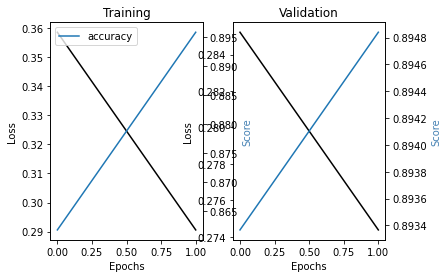

Model accuracy is :  0.8726164733634755
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2524
           1       0.87      0.88      0.87      2563

    accuracy                           0.87      5087
   macro avg       0.87      0.87      0.87      5087
weighted avg       0.87      0.87      0.87      5087



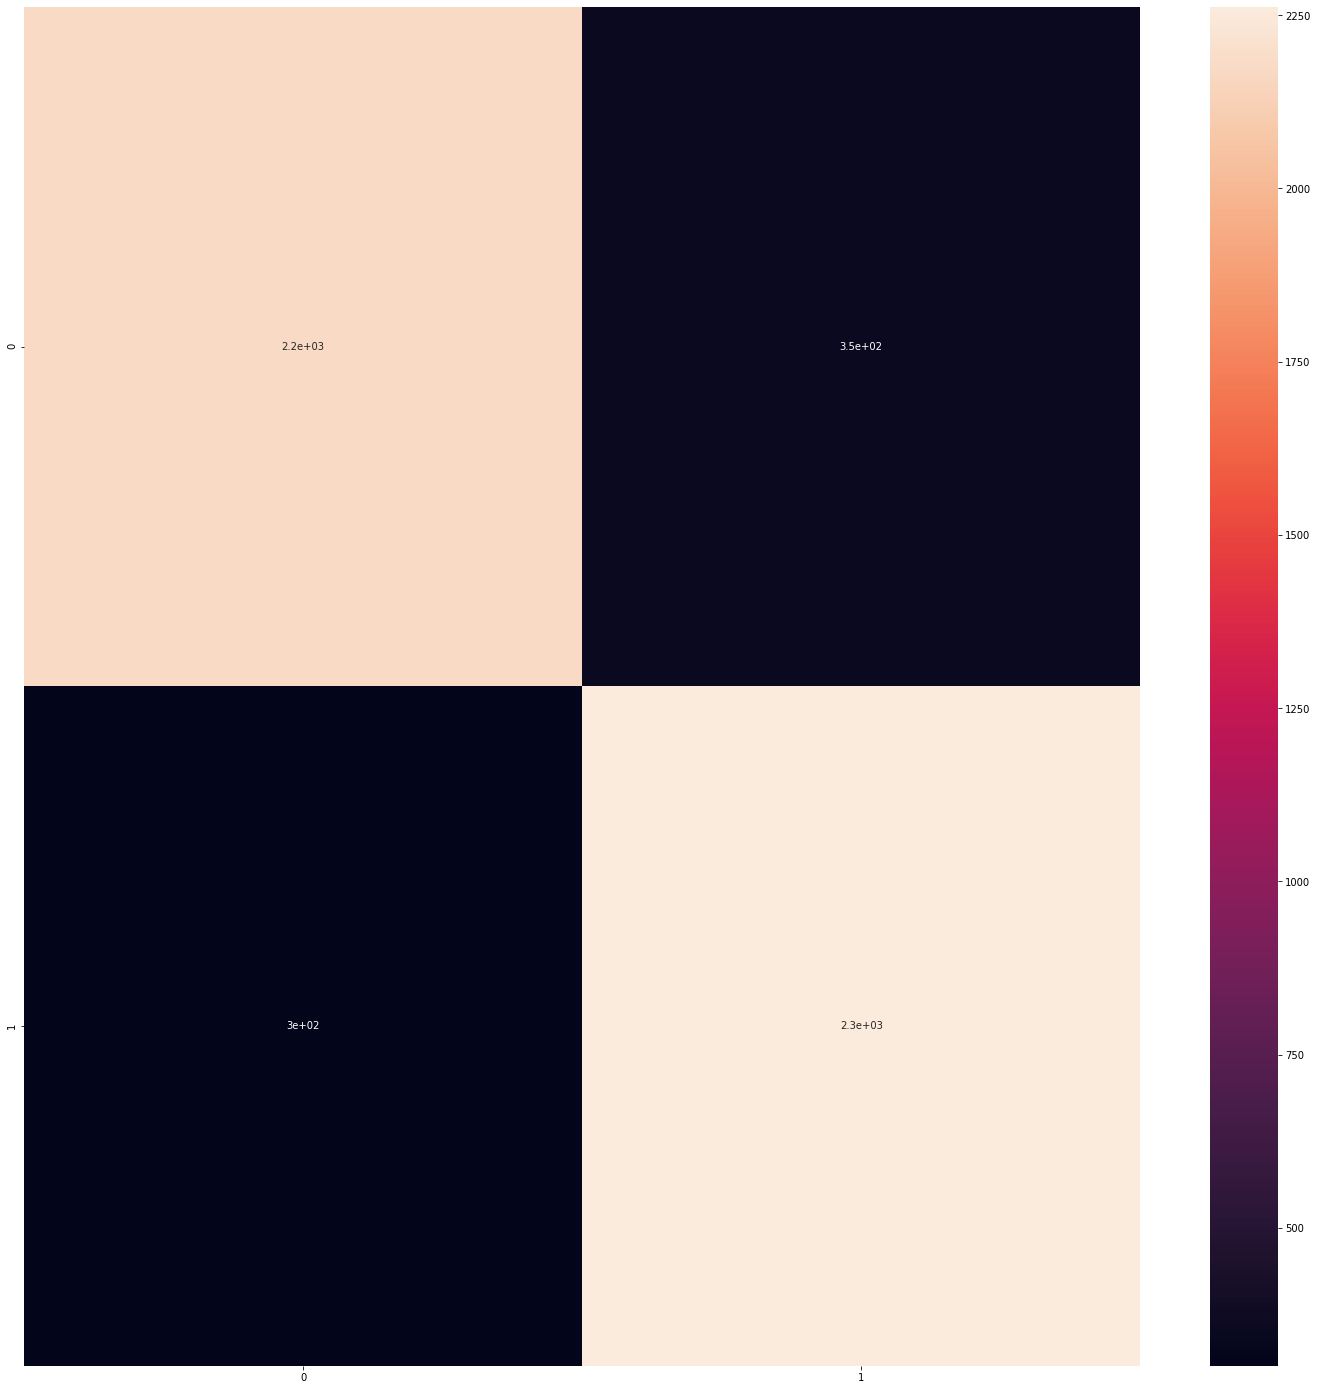

In [69]:
#ASSESING TRAINED MODEL PERFORMANCE

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

## Plot confusion matrix

pred = model.predict(padded_test)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

In [70]:
df_pred = pd.DataFrame(pred, columns = ['output'])

In [71]:
for X,Y,Z in zip(pred,y_test, x_test):
    print("Model Score:", X, "\nactual score:", Y, "\ntext:", Z, "\n-----------------------") 

Model Score: [0.8521759] 
actual score: 1 
text: evidence build soros evidence build soros george soros fund trump protest wishful think reader write soros involve destabilize overthrow democratically elect governmenbts world political social threat russia ukraine evidently western europe mass influx immigrant destabilise country clear trump putin threat common deal shadow government currently rattle strike soon recent violent event trump join russian government immediate arrest soros treasonous activity confiscate asset west appoint special prosecutor deal neocon criminal break buy pay press medium monopoly corrupt mendacious whore oligarchy furthermore shut oligarch create national bank issue debt free money fund infrastructure rebuild economy critically weaken opposition strengthen position deal shadow government force eternal enemy western people represent cancer kill host reconciliation deep thorough clean require rout viper audacity george soros extraordinary away post evidence b

actual score: 0 
text: civil museum close door politician demand confederate flag eliminate civil battlefield museum georgia close door local politician demand establishment discontinue confederate flag commissioner clemmons hampton georgia demand nash farm battlefield museum tear flag confederate display explain battle visitor museum decide close door say properly explain history half display censor wfmy report knight represent nonprofit group run museum say clemmons speak color authority county felt give choice close museum nash farm represent side conflict stuart carter supporter museum say establishment sure understand people image confederacy offensive carter add erase history remember mess group run museum insist properly relay history battle confederate artifact display county spokesperson say reasonable demand confederate flag display censor think reasonable think plenty artifact museum tell story civil think reasonable request county spokeswoman melissa robinson say controvers

Model Score: [0.628285] 
actual score: 1 
text: straight couple lose court battle enter civil partnership heterosexual couple lose legal battle enter civil partnership academic rebecca steinfeld charles keidan want secure legal recognition relationship enter civil partnership reject marriage claim carry patriarchal baggage prevent civil partnership stipulate couple eligible november couple daughter challenge decision high court judge justice andrew dismiss judicial review action tuesday challenge turn dismiss court appeal telegraph report address lady justice arden lord justice beatson lord justice briggs karon monaghan advance argument bar couple enter civil partnership incompatible article european convention relate discrimination take article refer respect private family life wish considerable importance enter legally regulate relationship carry patriarchal baggage consider come institution marriage say squire act behalf secretary state education responsibility equality government t

Model Score: [0.04614958] 
actual score: 0 
text: wayne album stall opinion flow york time wayne know relentless forward progress hold pattern choice year rapper decade career define prodigious output enmesh messy public contract dispute cash money record longtime label personal clash bos onetime father figure baby birdman addition solo album carter fate label imprint young money teeter balance wayne claim court properly compensate work help birth career drake nicki minaj string emotional tweet month wayne express exhaustion career status threaten retire defenseless mentally defeat leave gracefully thankful write add anxiety surround career series health scar include spate seizure recent year wayne prove vital sound renew torrent collaboration include work chainz collegrove appearance song chance rapper solange tuesday lieu music wayne release go november prison journal month spend bar rikers island possession slim book print line paper approximation handwrite evoke monotony jail flash

actual score: 1 
text: trump clinton recipient email enemy unite state joyously watch upcoming election expose great nation deeply corrupt huge rock turn expose swarm slither underside america political admire america like writer week time weep republic candidate utterly unfit high office hilary clinton engulf scandal bluster mogul donald trump profound shallowness advocate islamophobia torture environmental ignorance hillary clinton core supporter black food stamp welfare recipient legion woman vote simply gender trump core supporter pay worker watch wall street loot america economy send job abroad like people tear hair try decide vote favor libertarian party candidate gary johnson gain worldwide fame dolt ask destruction aleppo syria aleppo ask mexico bismarck kind president like regime changer empire builder imperial america crusader world super power bully muck world act globe enforcer forget aleppo beirut gaza tehran islamabad south china north korea long afford play game throne r

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 
text: associate deputy director assault weapon import nonsensical white paper publish washington post associate deputy director ronald turk show continue importation numerous assault weapon nonsensical reason assessment include grow similar rifle hunt shoot sport turk write sunset assault weapon similar rifle commonly refer modern sport rifle increase exponentially sport shoot firearm type standard hunt activity paradigm shift view usage assault weapon turk suggest review update study firearm clear reason lift importation limitation fact american manufacturer currently sell rifle identical similar firearm ban import restriction import serve questionable public safety interest turk note characteristic importation ban area modification rifle modification allow survive import restriction enter different classification classification mean unnecessary work importer paperwork address suppressor highlight broad hunt shoot sport suggest archaic continue regulate national firearm turk touch 

text: white house spox meryl streep deliver thoughtful carefully consider message breitbart monday white house daily brief ask sunday golden globe remark actress meryl streep criticize donald trump press secretary josh earnest say clearly deliver thoughtful carefully consider message believe deeply earnest say speak president speech speech certainly read plenty attention think clearly deliver thoughtful carefully consider message believe deeply fairly straight forward excise amendment right citizen unite state follow twitter pamkeynen 
-----------------------
Model Score: [0.01150274] 
actual score: 0 
text: aleppo donald trump istanbul morning brief york time good morning need know donald trump question remain bind longstanding china policy deal china thing include trade disparage american agency count commander chief dismiss assessment russian hack influence presidential campaign ridiculous trump expect secretary state tillerson chief executive exxon mobil extensive deal globe close 

actual score: 1 
text: small town attack african arab steal tool terrorise local police small german town sobernheim report group describe african arabic origin break construction site steal tool attack local attack report take place weekend march gang migrant roam small town population half thousand attack police break construction site town early even steal tool torment people town accord press release force witness rampage say gang number seven people attack individual midnight sunday morning police arm strike tool specify exact tool attack resident victim attack able nearby restaurant gang shortly migrant flee area damage street sign attack describe gang person african arabic origin police say person injure attack authority determine motive male participate incident catch arrest police authority reach public help identify responsible violence migrant settle germany migrant crisis place small town thousand resident year half relieve pressure nation large city significant problem sma

actual score: 0 
text: emmanuel macron inaugurate france president breitbart paris france president emmanuel macron formally take power sunday ceremony elysee presidential palace paris predecessor francois hollande welcome courtyard hundred journalist meet president office hollande departure take minute discus sensitive issue face france include country nuclear cod macron take charge nation britain leave european union member nuclear weapon permanent seat security council macron speech elysee reception hall guest official family member include wife brigitte macron wear lavender blue dress french designer nicolas ghesquiere louis vuitton macron wear dark suit french brand jonas tailor base paris cost euro team say follow ceremony military honor elysee palace macron tomb unknown soldier triomphe avenue tradition follow head state france modern history macron meet paris mayor anne hidalgo late sunday visit abroad germany monday visit german chancellor angela merkel berlin prime minister f

-----------------------
Model Score: [0.866622] 
actual score: 0 
text: hank game change team prepping miniseries trump election hank executive produce miniseries donald trump historic election stun victory hillary clinton accord hollywood reporter roach direct project gary goetzman sign executive produce trump miniseries base installment political commentary mark halperin john heilemann book game change roach hank goetzman collaborate halperin heilemann film game change chronicle presidential campaign senator john mccain governor alaska sarah palin installment game change describe breitbart news heinous piece propaganda contribution barack obama overall hackneyed political governor palin halperin heilemann bestseller game change obama clinton mccain palin race lifetime page long breitbart report film focus primarily palin largely ignore president obama course installment game change star harris julianne moore woody harrelson sarah paulson runaway success snag golden globe primetime em

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

